# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### MonteCarlo analysis
#### nVeloTracks intervals for MC simulations: Fits

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [2]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import matplotlib.pyplot as plt
import os
import mplhep
#ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
import RooPyFit as rpf
import RooPyShort as rsh

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()
mplhep.styles.use(mplhep.styles.LHCb2)

%jsroot

Welcome to JupyROOT 6.28/04
2024-06-20 12:02:50.084867
-------------------------
Set LHCb Style - May 2021
-------------------------


In [3]:
folders = ["Graphs", "root_files", "Results", "Tables"]

for f in folders:
    if not os.path.exists("./{0}".format(f)):
        os.makedirs("./{0}".format(f))

## RDataFrame definition

In [4]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'
    
dtt = "DsGammaTuple"

tdf_Dsst = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"DsstDsGamma*.root")
tdf_Dsst = tdf_Dsst.Define("DsgM", "Dsg_M-Ds_M+1969")
tdf_Dsst = tdf_Dsst.Define("PVZ_1PV", "PVZ[0]")
tdf_Dsst = tdf_Dsst.Define("Ds_log10_IPCHI2", "log10(Ds_IPCHI2_OWNPV)")

tdf_Ds1 = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"Ds1DsGamma*.root")
tdf_Ds1 = tdf_Ds1.Define("DsgM", "Dsg_M-Ds_M+1969")
tdf_Ds1 = tdf_Ds1.Define("PVZ_1PV", "PVZ[0]")
tdf_Ds1 = tdf_Ds1.Define("Ds_log10_IPCHI2", "log10(Ds_IPCHI2_OWNPV)")

## TRUEIDs and MCMatching

In [5]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_sig = tdf_Dsst.Filter(TRUEID_Dsst)
tdf_Ds1_sig = tdf_Ds1.Filter(TRUEID_Ds1)

In [6]:
off_sel  = "gamma_PT > 1255 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20 && DsgM < 2700"
nPVs_req = "nPVs == 1 && nVeloTracks <= 250 && PVZ_1PV < 140 && PVZ_1PV > -40"

L0_cond    = "(Ds_L0HadronDecision_TOS == 1 | Dsg_L0Global_TIS == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

MC_sel   = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds)

tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter(MC_sel)
tdf_Ds1_sig_sel = tdf_Ds1_sig.Filter(MC_sel)

L0_TIS_cond = "Dsg_L0Global_TIS == 1"

amount = "Run2"
Ds1_model = "CB"
prompt_check = False
TIS = True

if TIS:
    L0_trig = "TIS"
    tdf_Dsst_sig_sel = tdf_Dsst_sig_sel.Filter(L0_TIS_cond)
    tdf_Ds1_sig_sel = tdf_Ds1_sig_sel.Filter(L0_TIS_cond)
else:    
    L0_trig = "TISTOS"

if prompt_check:
    IP_cut = "tightIP"
    tdf_Dsst_sig_sel = tdf_Dsst_sig_sel.Filter("Ds_log10_IPCHI2 < {0}".format(0.4))
    tdf_Ds1_sig_sel = tdf_Ds1_sig_sel.Filter("Ds_log10_IPCHI2 < {0}".format(0.4))
else:
    IP_cut = "orIP"

In [6]:
dirty_trick = f"{off_sel} && {HLT1_cond} && {HLT2_cond}"

tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter(dirty_trick)
tdf_Ds1_sig_sel = tdf_Ds1_sig.Filter(dirty_trick)

### $\mathrm{N_{Tracks}^{VELO}}$ intervals

In [7]:
inters_path = "./Results"
inters_file = "Exp_Run2_nVeloTracks_binning_CB_TIS_orIP.txt"

nVelo_intervals = np.loadtxt("{0}/{1}".format(inters_path, inters_file))

ninters = len(nVelo_intervals) - 1

nVelo_cuts = ["nVeloTracks > {0} && nVeloTracks <= {1}".format(nVelo_intervals[i-1], nVelo_intervals[i]) for i in range(1, len(nVelo_intervals))]

Dsst_mass = "DsgM > 2050 && DsgM < 2250"
Ds1_mass = "DsgM > 2350 && DsgM < 2600"

MC_Dsg_Dsst_mass_sel_velo_cuts_hist = [tdf_Dsst_sig_sel.Filter("{0} && {1}".format(Dsst_mass, inter)).Histo1D(("","",100,2050,2250), "DsgM") for inter in nVelo_cuts] 
MC_Dsg_Ds1_mass_sel_velo_cuts_hist  = [tdf_Ds1_sig_sel.Filter("{0} && {1}".format(Ds1_mass, inter)).Histo1D(("","",100,2350,2600), "DsgM") for inter in nVelo_cuts] 

In [8]:
i = 0; j = 0

c1 = ROOT.TCanvas("", "", 800, 600)
lgd = ROOT.TLegend(0.57, 0.44, 0.92, 0.87)
for x in MC_Dsg_Dsst_mass_sel_velo_cuts_hist:
    i += 1
    rsh.TH1D_plot(x, color=i, norm=True)
rsh.legend_plot(lgd, [x.GetPtr() for x in MC_Dsg_Dsst_mass_sel_velo_cuts_hist], 
                ["{0}º nVeloTracks interval".format(i+1) for i in range(len(MC_Dsg_Dsst_mass_sel_velo_cuts_hist))],
                ["l" for x in MC_Dsg_Dsst_mass_sel_velo_cuts_hist])
c1.Draw()
c1.SaveAs("Graphs/Sim_Dsg_mass_Dsst_Velo_cuts_{0}_{1}.pdf".format(L0_trig, IP_cut))
    
c2 = ROOT.TCanvas("", "", 800, 600)
lgd2 = ROOT.TLegend(0.3, 0.22, 0.65, 0.65)
for x in MC_Dsg_Ds1_mass_sel_velo_cuts_hist:
    j += 1
    rsh.TH1D_plot(x, color=j, norm=True)
rsh.legend_plot(lgd2, [x.GetPtr() for x in MC_Dsg_Ds1_mass_sel_velo_cuts_hist], 
                ["{0}º nVeloTracks interval".format(i+1) for i in range(len(MC_Dsg_Ds1_mass_sel_velo_cuts_hist))],
                ["l" for x in MC_Dsg_Ds1_mass_sel_velo_cuts_hist])
c2.Draw()
c2.SaveAs("Graphs/Sim_Dsg_mass_Ds1_Velo_cuts_{0}_{1}.pdf".format(L0_trig, IP_cut))

Info in <TCanvas::Print>: pdf file Graphs/Sim_Dsg_mass_Dsst_Velo_cuts_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_Dsg_mass_Ds1_Velo_cuts_TIS_orIP.pdf has been created


In [9]:
tdf_Dsst_mass_sel_velo_cuts = [tdf_Dsst_sig_sel.Filter("{0} && {1}".format(Dsst_mass, inter)) for inter in nVelo_cuts] 
tdf_Ds1_mass_sel_velo_cuts = [tdf_Ds1_sig_sel.Filter("{0} && {1}".format(Ds1_mass, inter)) for inter in nVelo_cuts]

MC_Dsg_Dsst_mass_sel_velo_cuts = [x.AsNumpy(["DsgM"]) for x in tdf_Dsst_mass_sel_velo_cuts] 
MC_Dsg_Ds1_mass_sel_velo_cuts = [x.AsNumpy(["DsgM"]) for x in tdf_Ds1_mass_sel_velo_cuts]

## $D_s^{*+}\to D_s^+\gamma$ model

In [10]:
mDsst = ROOT.RooRealVar("DsgM", "DsgM", 2050, 2250)

### Signal PDF

In [11]:
mu_c = 2112
sigma_c = 10
alpha_c = 1
n_c = 4

mu_Dsst = ROOT.RooRealVar("mu_Dsst", "mu_Dsst", mu_c, mu_c-10, mu_c+10)
sigma_Dsst = ROOT.RooRealVar("sigma_Dsst", "sigma_Dsst", 0.5*sigma_c, 0.2*sigma_c, 2*sigma_c)
alphaL_Dsst = ROOT.RooRealVar("alphaL_Dsst", "alphaL_Dsst", alpha_c, 0.01*alpha_c, 10*alpha_c)
nL_Dsst = ROOT.RooRealVar("nL_Dsst", "nL_Dsst", n_c, 1, 100)
alphaR_Dsst = ROOT.RooRealVar("alphaR_Dsst", "alphaR_Dsst", alpha_c, 0.01*alpha_c, 10*alpha_c)
nR_Dsst = ROOT.RooRealVar("nR_Dsst", "nR_Dsst", n_c, 1, 100)

CB_Dsst = ROOT.RooCrystalBall("CB_Dsst", "CB_Dsst",
                               mDsst, mu_Dsst, sigma_Dsst, 
                               alphaL_Dsst, nL_Dsst,
                               alphaR_Dsst, nR_Dsst)

units_CB = ["", "", "", "", "", ""]


## $D_{s1}(2460)^+\to D_s^+\gamma$ model

In [12]:
mDs1 = ROOT.RooRealVar("DsgM", "DsgM", 2350, 2600)

### Signal PDF

In [13]:
mu_c = 2460
sigma_c = 20
alpha_c = 1
n_c = 2

mu_Ds1 = ROOT.RooRealVar("mu_Ds1", "mu_Ds1", mu_c, mu_c-20, mu_c+20)
sigma_Ds1 = ROOT.RooRealVar("sigma_Ds1", "sigma_Ds1", sigma_c, 0.1*sigma_c, 2*sigma_c)
alphaL_Ds1 = ROOT.RooRealVar("alphaL_Ds1", "alphaL_Ds1", alpha_c, 0.5*alpha_c, 5*alpha_c)
nL_Ds1 = ROOT.RooRealVar("nL_Ds1", "nL_Ds1", n_c, 1, 100)
alphaR_Ds1 = ROOT.RooRealVar("alphaR_Ds1", "alphaR_Ds1", alpha_c, 0.5*alpha_c, 5*alpha_c)
nR_Ds1 = ROOT.RooRealVar("nR_Ds1", "nR_Ds1", n_c, 1, 100)

CB_Ds1 = ROOT.RooCrystalBall("CB_Ds1", "CB_Ds1",
                             mDs1, mu_Ds1, sigma_Ds1, 
                             alphaL_Ds1, nL_Ds1, 
                             alphaR_Ds1, nR_Ds1)

units_CB = ["", "", "", "", "", ""]

## nVeloTracks intervals fits

In [14]:
Dsst_fits_vals = []; Dsst_fits_uncs = [] 
Ds1_fits_vals  = []; Ds1_fits_uncs  = []

i = 0

In [15]:
for (x,y) in zip(MC_Dsg_Dsst_mass_sel_velo_cuts, MC_Dsg_Ds1_mass_sel_velo_cuts):
    
    dh_Dsst = ROOT.RooDataSet.from_numpy(x, [mDsst])
    dh_Ds1 = ROOT.RooDataSet.from_numpy(y, [mDs1])

    Dsst_fit = rpf.Fit(CB_Dsst.fitTo(dh_Dsst, ROOT.RooFit.Save()))
    Dsst_fit.print()
    Dsst_fit.save_to_latex(mDsst, dh_Dsst, CB_Dsst, units_CB, 
                           file_name="Tables/Sim_DsgL_Dsst_sig_mass_fit_CB_{0}Velo_{1}_{2}_{3}.tex".format(ninters, i, L0_trig, IP_cut), fit_type="u")
    rpf.plot(mDsst, dh_Dsst, CB_Dsst, 
             file_name="Graphs/Sim_DsgL_Dsst_sig_mass_fit_CB_{0}Velo_{1}_{2}_{3}.pdf".format(ninters, i, L0_trig, IP_cut))

    Ds1_fit = rpf.Fit(CB_Ds1.fitTo(dh_Ds1, ROOT.RooFit.Save()))
    Ds1_fit.print()
    Ds1_fit.save_to_latex(mDs1, dh_Ds1, CB_Ds1, units_CB, 
                          file_name="Tables/Sim_DsgL_Ds1_sig_mass_fit_CB_{0}Velo_{1}_{2}_{3}.tex".format(ninters, i, L0_trig, IP_cut), fit_type="u")
    rpf.plot(mDs1, dh_Ds1, CB_Ds1, 
             file_name="Graphs/Sim_DsgL_Ds1_sig_mass_fit_CB_{0}Velo_{1}_{2}_{3}.pdf".format(ninters, i, L0_trig, IP_cut))
    
    Dsst_vals = Dsst_fit.par_values(); Dsst_uncs = Dsst_fit.par_errors(); Dsst_pars = Dsst_fit.par_names()
    Ds1_vals = Ds1_fit.par_values(); Ds1_uncs = Ds1_fit.par_errors(); Ds1_pars = Ds1_fit.par_names()
    
    Dsst_fits_vals.append(Dsst_vals); Dsst_fits_uncs.append(Dsst_uncs)
    Ds1_fits_vals.append(Ds1_vals); Ds1_fits_uncs.append(Ds1_uncs)
    
    i += 1

------------------------------------------------
Fit status = 0
EDM = 4.0558702370516024e-05
-log(L) minimum = 1558.8026395132706
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.6680046316897632
------------------------------------------------
Fit status = 0
EDM = 5.0329074948062415e-06
-log(L) minimum = 35790.83034652182
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.974791581165279
------------------------------------------------
Fit status = 0
EDM = 9.05760134242202e-06
-log(L) minimum = 1342.663941583666
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.545985136775371
------------------------------------------------
Fit status = 0
EDM = 3.5276291834328864e-05
-log(L) minimum = 31473.834725220888
final value of floating parame

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_fit_CB_5Velo_0_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_sig_mass_fit_CB_5Velo_0_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_fit_CB_5Velo_1_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_sig_mass_fit_CB_5Velo_1_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_fit_CB_5Velo_2_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_sig_mass_fit_CB_5Velo_2_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_fit_CB_5Velo_3_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_sig_mass_fit_CB_5Velo_3_TIS_orIP.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_fit_CB_5Velo_4_TIS_orIP.pdf has been created
Info in <TCanv

In [22]:
df_Dsst_fits_vals = (pd.DataFrame(np.array(Dsst_fits_vals))).set_axis(Dsst_pars, axis='columns')
df_Dsst_fits_uncs = (pd.DataFrame(np.array(Dsst_fits_uncs))).set_axis(Dsst_pars, axis='columns')

df_Ds1_fits_vals = (pd.DataFrame(np.array(Ds1_fits_vals))).set_axis(Ds1_pars, axis='columns')
df_Ds1_fits_uncs = (pd.DataFrame(np.array(Ds1_fits_uncs))).set_axis(Ds1_pars, axis='columns')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [17]:
nVelo_inter_avg = np.array([tdf_Ds1_sig_sel.Filter(Ds1_mass+"&&"+x).Mean("nVeloTracks").GetValue() for x in nVelo_cuts])
nVelo_inter_min = np.array([tdf_Ds1_sig_sel.Filter(Ds1_mass+"&&"+x).Min("nVeloTracks").GetValue() for x in nVelo_cuts])
nVelo_inter_max = np.array([tdf_Ds1_sig_sel.Filter(Ds1_mass+"&&"+x).Max("nVeloTracks").GetValue() for x in nVelo_cuts])

nVelo_inter_udown = nVelo_inter_avg - nVelo_inter_min
nVelo_inter_uup   = nVelo_inter_max - nVelo_inter_avg

In [18]:
df_Dsst_fits_vals.insert(2, "nVelo_mean", nVelo_inter_avg)
df_Dsst_fits_vals.insert(2, "nVelo_udown", nVelo_inter_udown)
df_Dsst_fits_vals.insert(2, "nVelo_uup", nVelo_inter_uup)

df_Dsst_fits_uncs.insert(2, "nVelo_mean", nVelo_inter_means)
df_Dsst_fits_uncs.insert(2, "nVelo_udown", nVelo_inter_udown)
df_Dsst_fits_uncs.insert(2, "nVelo_uup", nVelo_inter_uup)

df_Ds1_fits_vals.insert(2, "nVelo_mean", nVelo_inter_means)
df_Ds1_fits_vals.insert(2, "nVelo_udown", nVelo_inter_udown)
df_Ds1_fits_vals.insert(2, "nVelo_uup", nVelo_inter_uup)

df_Ds1_fits_uncs.insert(2, "nVelo_mean", nVelo_inter_means)
df_Ds1_fits_uncs.insert(2, "nVelo_udown", nVelo_inter_udown)
df_Ds1_fits_uncs.insert(2, "nVelo_uup", nVelo_inter_uup)

In [ ]:
df_Dsst_fits_vals.to_csv("Results/Sim_DsgL_Dsst_sig_mass_fit_CB_vals_{0}Velo_{1}_{2}.csv".format(ninters, L0_trig, IP_cut), index=False)
df_Dsst_fits_uncs.to_csv("Results/Sim_DsgL_Dsst_sig_mass_fit_CB_uncs_{0}Velo_{1}_{2}.csv".format(ninters, L0_trig, IP_cut), index=False)

df_Ds1_fits_vals.to_csv("Results/Sim_DsgL_Ds1_sig_mass_fit_CB_vals_{0}Velo_{1}_{2}.csv".format(ninters, L0_trig, IP_cut), index=False)
df_Ds1_fits_uncs.to_csv("Results/Sim_DsgL_Ds1_sig_mass_fit_CB_uncs_{0}Velo_{1}_{2}.csv".format(ninters, L0_trig, IP_cut), index=False)

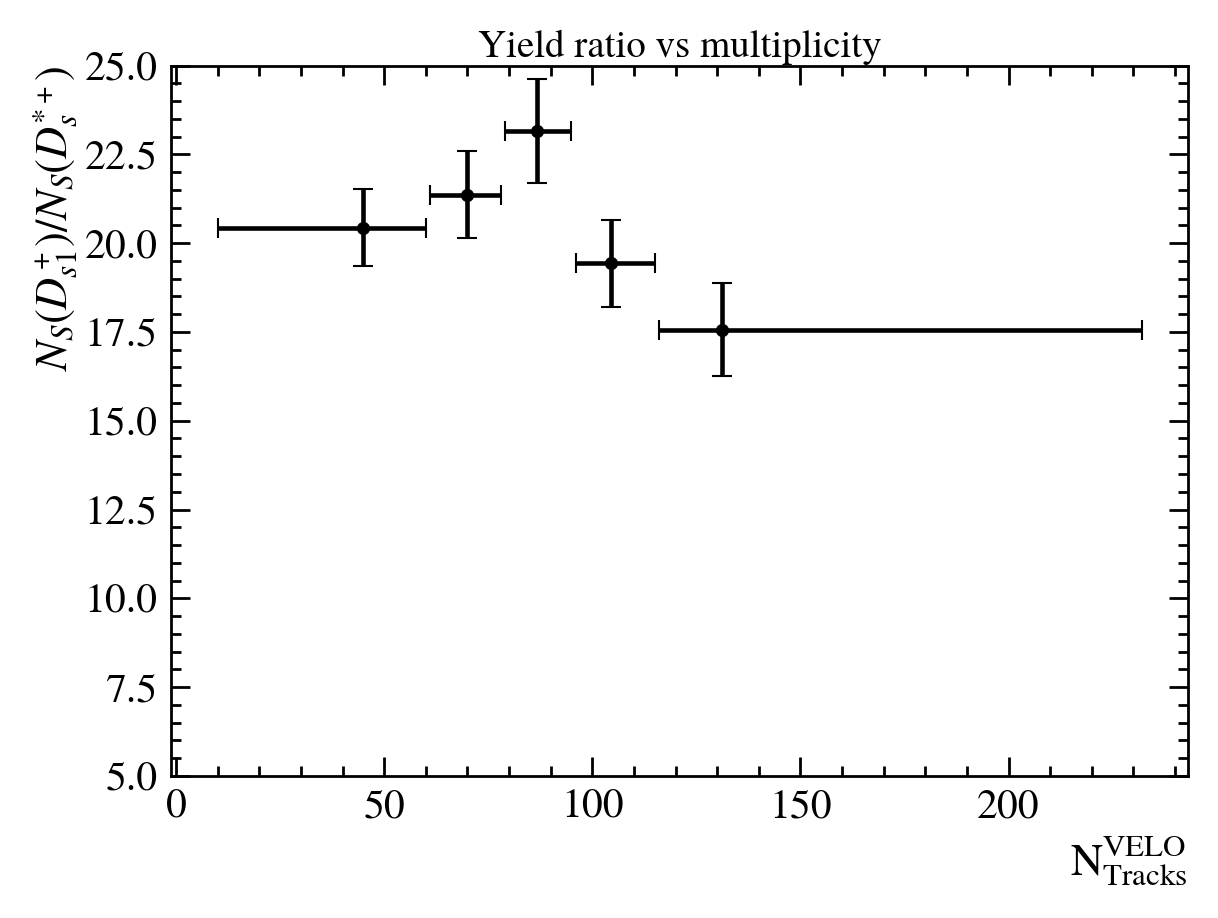

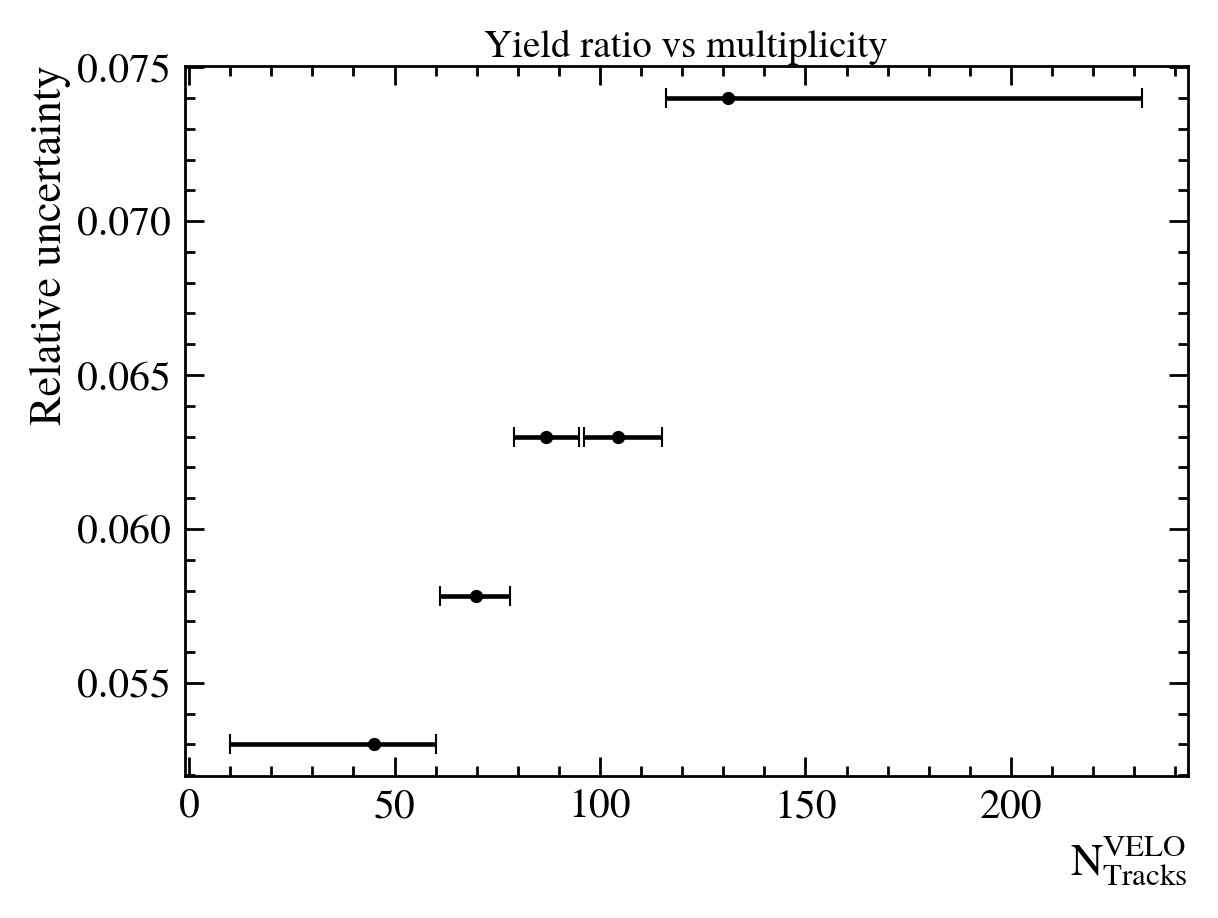

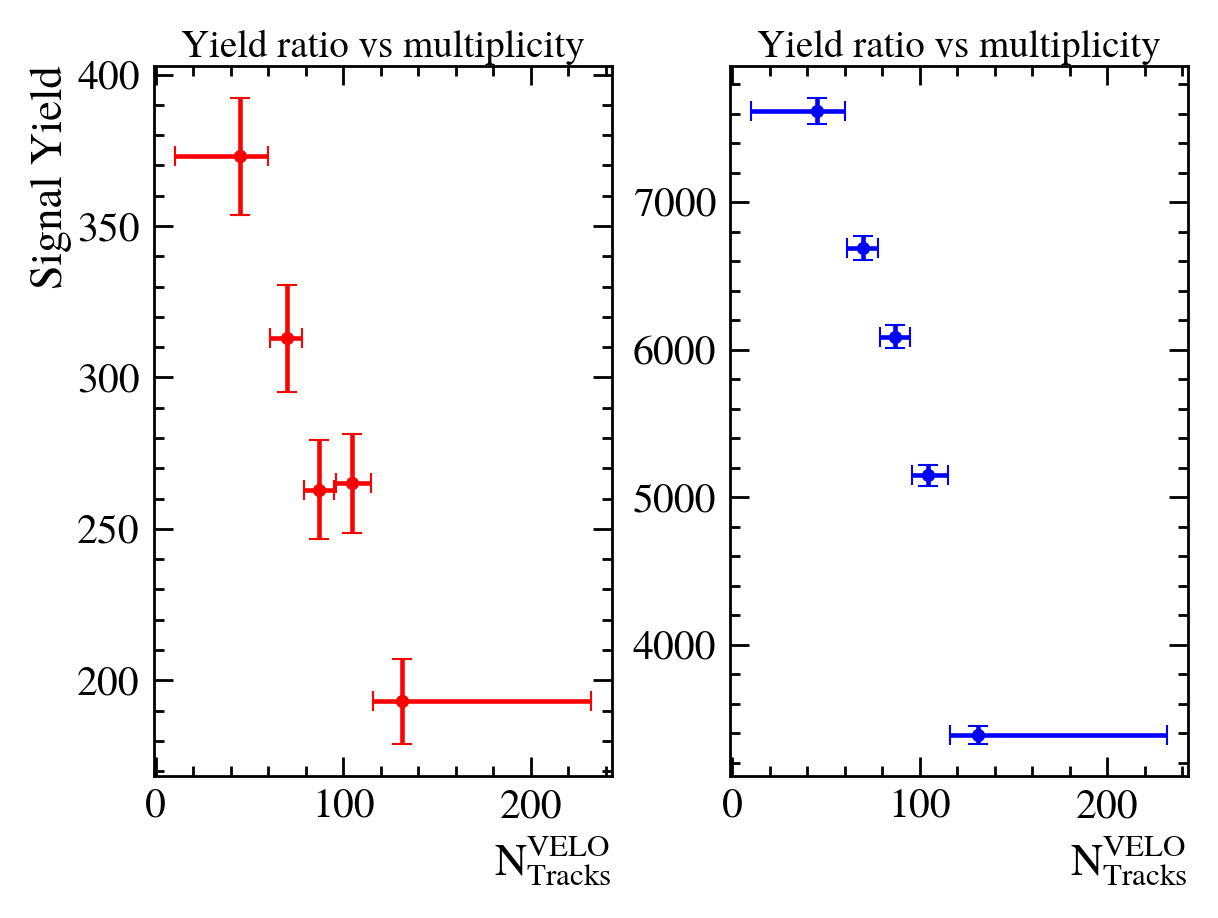

In [20]:
def uratio(a, b, ua, ub):
    ratio = a/b
    uratio = ratio * np.sqrt((ua/a)**2+(ub/b)**2)
    return uratio

MC_Dsg_Dsst_mass_sel_velo_cuts_I = np.array([hist.Integral() for hist in MC_Dsg_Dsst_mass_sel_velo_cuts_hist]) 
MC_Dsg_Ds1_mass_sel_velo_cuts_I  = np.array([hist.Integral() for hist in MC_Dsg_Ds1_mass_sel_velo_cuts_hist]) 

Ds1_Dsst_ratio = MC_Dsg_Ds1_mass_sel_velo_cuts_I / MC_Dsg_Dsst_mass_sel_velo_cuts_I
uDs1_Dsst_ratio = uratio(MC_Dsg_Ds1_mass_sel_velo_cuts_I, MC_Dsg_Dsst_mass_sel_velo_cuts_I,
                         np.sqrt(MC_Dsg_Ds1_mass_sel_velo_cuts_I), np.sqrt(MC_Dsg_Dsst_mass_sel_velo_cuts_I))

plt.figure(1)
plt.errorbar(nVelo_inter_means, Ds1_Dsst_ratio, yerr=uDs1_Dsst_ratio,
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="k", ecolor="k", capsize=7)
plt.ylim(5, 25)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$N_S(D_{s1}^+)/N_S(D_s^{*+})$")
plt.title("Yield ratio vs multiplicity")
plt.savefig("Graphs/Sim_DsgL_yield_ratio_{0}Velo_{1}_{2}.pdf".format(ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_inter_avg, uDs1_Dsst_ratio / Ds1_Dsst_ratio, yerr=0,
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="k", ecolor="k", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"Relative uncertainty")
plt.title("Yield ratio vs multiplicity")
plt.savefig("Graphs/Sim_DsgL_yield_ratio_ru_{0}Velo_{1}_{2}.pdf".format(ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

plt.figure(3)
plt.subplot(121)
plt.errorbar(nVelo_inter_avg, MC_Dsg_Dsst_mass_sel_velo_cuts_I, np.sqrt(MC_Dsg_Dsst_mass_sel_velo_cuts_I),
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"Signal Yield")
plt.title("Yield ratio vs multiplicity")
plt.subplot(122)
plt.errorbar(nVelo_inter_avg, MC_Dsg_Ds1_mass_sel_velo_cuts_I, yerr=np.sqrt(MC_Dsg_Ds1_mass_sel_velo_cuts_I),
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.title("Yield ratio vs multiplicity")
plt.savefig("Graphs/Sim_DsgL_Both_yields_{0}Velo_{1}_{2}.pdf".format(ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

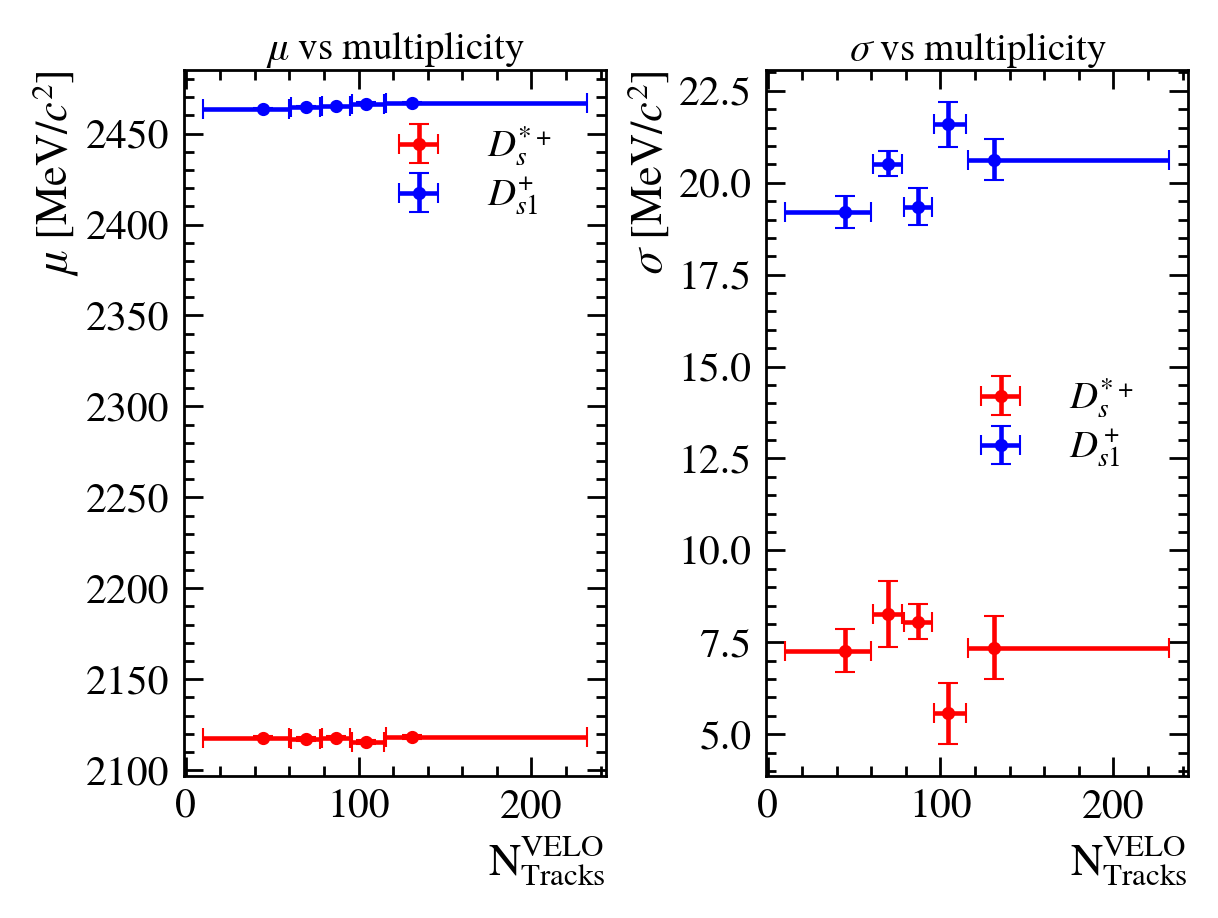

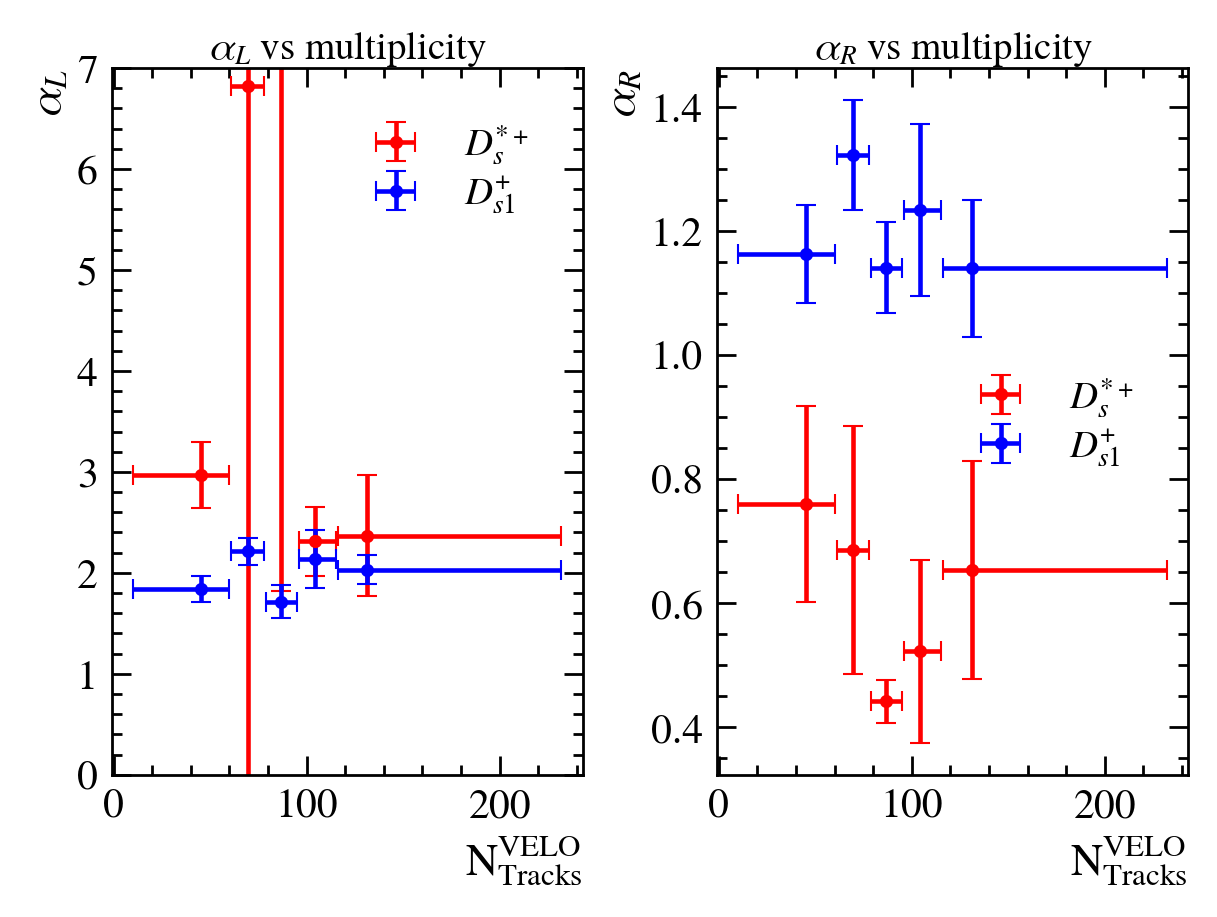

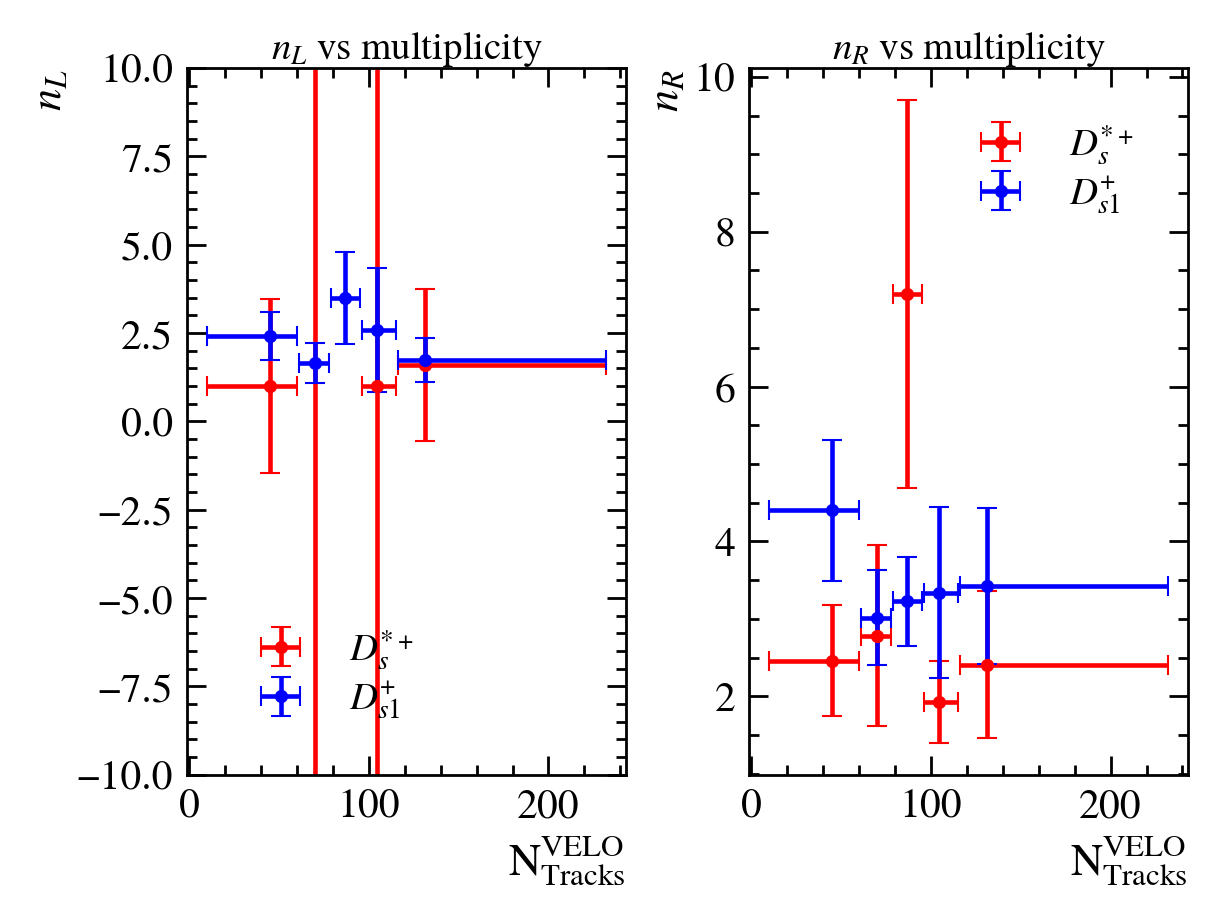

In [21]:
plt.figure(1)
plt.subplot(121)
plt.errorbar(nVelo_inter_means, df_Dsst_fits_vals["mu_Dsst"], df_Dsst_fits_uncs["mu_Dsst"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7, label="$D_s^{*+}$")
plt.errorbar(nVelo_inter_means, df_Ds1_fits_vals["mu_Ds1"], df_Ds1_fits_uncs["mu_Ds1"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7, label="$D_{s1}^{+}$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\mu$ [MeV/$c^2$]")
plt.title(r"$\mu$ vs multiplicity")
plt.legend()
plt.subplot(122)
plt.errorbar(nVelo_inter_means, df_Dsst_fits_vals["sigma_Dsst"], df_Dsst_fits_uncs["sigma_Dsst"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7, label="$D_s^{*+}$")
plt.errorbar(nVelo_inter_means, df_Ds1_fits_vals["sigma_Ds1"], df_Ds1_fits_uncs["sigma_Ds1"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7, label="$D_{s1}^+$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\sigma$ [MeV/$c^2$]")
plt.title(r"$\sigma$ vs multiplicity")
plt.legend()
plt.savefig("Graphs/Sim_DsgL_Both_muwidCB_{0}Velo_{1}_{2}.pdf".format(ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')


plt.figure(2)
plt.subplot(121)
plt.errorbar(nVelo_inter_means, df_Dsst_fits_vals["alphaL_Dsst"], df_Dsst_fits_uncs["alphaL_Dsst"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7, label="$D_s^{*+}$")
plt.errorbar(nVelo_inter_means, df_Ds1_fits_vals["alphaL_Ds1"], df_Ds1_fits_uncs["alphaL_Ds1"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7, label="$D_{s1}^{+}$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\alpha_L$")
plt.title(r"$\alpha_L$ vs multiplicity")
plt.legend()
plt.ylim(0, 7)
plt.subplot(122)
plt.errorbar(nVelo_inter_means, df_Dsst_fits_vals["alphaR_Dsst"], df_Dsst_fits_uncs["alphaR_Dsst"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7, label="$D_s^{*+}$")
plt.errorbar(nVelo_inter_means, df_Ds1_fits_vals["alphaR_Ds1"], df_Ds1_fits_uncs["alphaR_Ds1"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7, label="$D_{s1}^{+}$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\alpha_R$")
plt.title(r"$\alpha_R$ vs multiplicity")
plt.legend()
plt.savefig("Graphs/Sim_DsgL_Both_alphaCB_{0}Velo_{1}_{2}.pdf".format(ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

plt.figure(3)
plt.subplot(121)
plt.errorbar(nVelo_inter_means, df_Dsst_fits_vals["nL_Dsst"], df_Dsst_fits_uncs["nL_Dsst"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7, label="$D_s^{*+}$")
plt.errorbar(nVelo_inter_means, df_Ds1_fits_vals["nL_Ds1"], df_Ds1_fits_uncs["nL_Ds1"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7, label="$D_{s1}^{+}$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$n_L$")
plt.ylim(-10, 10)
plt.title(r"$n_L$ vs multiplicity")
plt.legend()

plt.subplot(122)
plt.errorbar(nVelo_inter_means, df_Dsst_fits_vals["nR_Dsst"], df_Dsst_fits_uncs["nR_Dsst"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="r", ecolor="r", capsize=7, label="$D_s^{*+}$")
plt.errorbar(nVelo_inter_means, df_Ds1_fits_vals["nR_Ds1"], df_Ds1_fits_uncs["nR_Ds1"],
             xerr=[df_Ds1_fits_vals["nVelo_udown"], df_Ds1_fits_vals["nVelo_uup"]], 
             fmt='.', color="b", ecolor="b", capsize=7, label="$D_{s1}^{+}$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$n_R$")
plt.title(r"$n_R$ vs multiplicity")
plt.legend()
plt.savefig("Graphs/Sim_DsgL_Both_nCB_{0}Velo_{1}_{2}.pdf".format(ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')